# Gif87a
[gif 87a 用プログラム](http://fortran66.hatenablog.com/entry/2018/05/12/170408)

In [1]:
%fcflags:-fno-range-check
    module m_gif_types
        use, intrinsic :: iso_fortran_env
        implicit none    
        private
        public :: t_gif_header, t_image_block, int8

        interface t_gif_header
            procedure :: init_gif_header
        end interface 
        
        interface t_image_block
            procedure :: init_image_block
        end interface 
        
        type :: t_gif_header
            sequence  
            character(3)   :: signature               = 'GIF'
            character(3)   :: version                 = '87a'
            integer(int16) :: width     
            integer(int16) :: height    
            integer(int8)  :: pck                     = int(B'10001000', int8) 
                                                        !1:Global Col. 3:Color Res. 1:Sort Flg. 3:Size of Global Col.
            integer(int8)  :: background_color_index  = 0
            integer(int8)  :: pixel_aspect_ratio      = 0
        end type  
        
        type :: t_image_block
            sequence
            integer(int8)  :: separator               = int(Z'2C', int8)
            integer(int16) :: left_position           = 00
            integer(int16) :: top_position            = 00
            integer(int16) :: width  
            integer(int16) :: height 
            integer(int8)  :: pck                     = int(B'00000000', int8)
            ! local color table
            !integer(int8) :: LZW_minimum_code_size 
            !integer(int8) :: block_size  
            !integer(int8) :: image_data (:)
            !integer(int8) :: block_terminator        = int(Z'00', int8)  
        end type t_image_block
    contains
        pure type(t_gif_header) function init_gif_header(nx, ny, ngcol) result(res)
            integer, intent(in) :: nx, ny, ngcol
            res%width  = nx
            res%height = ny
            res%pck = iand(res%pck, int(B'11111000', int8)) + int(mod(ngcol, 8), int8) 
                      !least 3bits:size of global color:2**(ngcol + 1) 2..256
        end function init_gif_header
    
        pure type(t_image_block) function init_image_block(nx, ny) result(res)
            integer, intent(in) :: nx, ny
            res%width  = nx
            res%height = ny
        end function init_image_block
    end module m_gif_types 

    
    module m_gif_lzw
        use :: m_gif_types
        implicit none
        private
        public :: encoder
        type :: t_enc
            integer :: kbits = 0, id = 0
        end type    
    contains
        subroutine enc(irgb, nbits, code)               ! gif LZW 
            integer, intent(in) :: irgb(:), nbits
            type (t_enc), intent(out) :: code(:)
            integer :: dict(0:2**12 - 1) ! 0:4095
            integer :: kbits, kd, m0                    ! <== m0 state variable
            integer :: ip, ic, ienc
            call clear_dict()                           ! clear dictionary 
            ic = 1
            code(ic) = t_enc(kbits, 2**nbits)           ! clear_code 
            m0 = irgb(1)
            do ip = 2, size(irgb)
                call subenc(ienc, irgb(ip)) 
                if (ienc /= -1) then                    ! new word 
                     ic = ic + 1
                     code(ic) = t_enc(kbits, ienc)
                end if  
                if (kd == 2**12 - 1) then               ! dictionary full
                    ic = ic + 1  
                    code(ic) = t_enc(kbits, 2**nbits)   ! clear_code
                    call clear_dict()                   ! clear dictionary 
                end if
            end do
            ic = ic + 1
            code(ic) = t_enc(kbits, m0)
            ic = ic + 1 
            code(ic) = t_enc(kbits, dict(2**nbits + 1)) ! end_code  
        contains
            subroutine subenc(ienc, m1)
                integer, intent(out) :: ienc
                integer, intent(in ) :: m1
                integer :: k, id
                k = ishft(m0 + 1, 16) + m1              ! m0 + 1 to avoid 00...0 degeneracy 
                id = findloc(dict, k, dim = 1)          ! dictionary is 0-based 
                if (id == 0) then                       ! not found in the dictionary
                    kd = kd + 1
                    dict(kd) = k
                    if (kd == 2**kbits + 1) kbits = kbits + 1
                    ienc = m0
                    m0 = m1
                else                                    ! found in the dictionary
                    ienc = -1
                    m0 = id - 1                         ! because dictionary is 0-based, m0 must be shifted by 1
                end if    
            end subroutine subenc

            subroutine clear_dict()
                integer :: i
                kbits = nbits + 1
                kd = 2**nbits + 1 ! dictinary defined
                dict = 0
                forall(i = 0:kd) dict(i) = i ! dict(nbit):clear code; dict(nbit+1):end code 
            end subroutine clear_dict
        end subroutine enc
      
        subroutine encoder(irgb, nbits, icode)
            integer, intent(in ) :: irgb(:), nbits
            integer(int8), allocatable, intent(out) :: icode(:)
            type(t_enc), allocatable :: code(:)
            integer :: i, j, k, ib, ic, nb  
            allocate(code(size(irgb) + 100))            ! ? large enough ?
            call enc(irgb, nbits, code)                 ! compress color code to LZW code
            nb = ceiling(sum(code(:)%kbits) / 8.0)      !   required bytes  
            allocate(icode(nb))
            icode = 0                                   ! pack LZW code to bit string    
            k = 0
            do i = 1, size(code)                          
                do j = 1, code(i)%kbits   
                    if (btest(code(i)%id, j - 1)) then 
                        ic = k / 8 + 1 
                        ib = mod(k, 8)
                        icode(ic) = ibset(icode(ic), ib)
                    end if
                    k = k + 1
                end do  
            end do            
        end subroutine encoder 
    end module m_gif_lzw
    
    
    module m_gif
        use :: m_gif_types
        use :: m_gif_lzw
        implicit none
        private
        public :: wr_gif
    contains
        subroutine wr_gif(fn, irgb2, n_global_color, global_color_table) 
            character(*), intent(in) :: fn
            integer, intent(in), contiguous, target :: irgb2(:, :)
            integer, intent(in) :: n_global_color, global_color_table(:)
            integer(int8), allocatable :: icode(:)
            integer, pointer :: irgb(:)
            type(t_gif_header ) :: head
            type(t_image_block) :: img
            integer :: nx, ny, iw, nbits
            nx = size(irgb2, 1)
            ny = size(irgb2, 2)
            nbits = max(2, n_global_color + 1)           ! 1..8 -> 2,2,3,4,5,6,7,8
            head = t_gif_header(nx, ny, n_global_color)
            img  = t_image_block(nx, ny)
            open(newunit = iw, file = fn, access = 'stream') 
            write(iw) head      
            write(iw) int(global_color_table, int8)
            write(iw) img    
            irgb(1:size(irgb2)) => irgb2                 ! 1D => 2D 
            call encoder(irgb, nbits, icode)             ! color code to GIF LZW code         
            block
                integer :: i, nbyte
                write(iw) int(nbits, int8)               ! LZW_minimum_code_size = 2,2,3,4,5,6,7,8   
                do i = 1, size(icode), 255         
                    nbyte = min(i + 255, size(icode)) - i
                    write(iw) achar(nbyte)             
                    write(iw) icode(i:i+nbyte-1)
                end do  
                write(iw) achar(00)                      ! block_terminator
            end block
            write(iw) achar(int(Z'3B'))                  ! end of gif file
            close(iw)
        end subroutine wr_gif  
    end module m_gif
    
    
    program mandel
        implicit none
        integer, parameter :: nx = 500, ny = 500, maxiter = 255
        real   , parameter :: x0 = -2.0, x1 = 1.0, y0 = -1.5, y1 = 1.5
        complex, allocatable :: c(:, :), z(:, :)                 
        integer, allocatable :: niter(:, :)
        integer :: ix, iy, iter
        allocate(c(nx, ny), z(nx, ny), niter(nx, ny))    ! make 2D-mesh   
! Mandelbrot set
        forall(ix = 1:nx, iy = 1:ny) &
              c(ix, iy) = cmplx(x0, y0) &
                        + cmplx((x1 - x0) / (nx - 1) * (ix - 1), (y1 - y0) / (ny - 1) * (iy - 1))
        niter = 0
        do iter = 1, maxiter
            where (abs(z) <= 2.0) 
                z = z**2 + c
                niter = niter + 1
            end where 
        end do
!  
        block                                            ! set global color table
            integer :: i, n_global_color                    ! 0..7 ! 2..256 colors (2^(n_global_color + 1)) 
            integer, allocatable :: global_color_table(:)
            n_global_color = 7
            allocate(global_color_table(3 * 2**(n_global_color + 1)))
            global_color_table = 0
            forall(i = 0:254) global_color_table(3*i+1:3*i+3) = i   ! BW 256
! write gif file
            block
                use :: m_gif
                call wr_gif('mandel.gif', niter, n_global_color, global_color_table)
            end block
        end block
    end program mandel

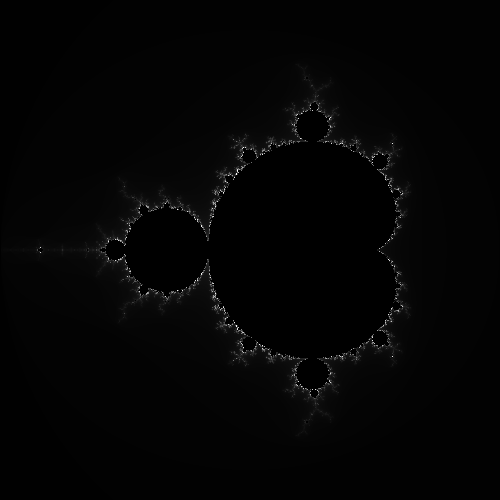

In [2]:
%image:mandel.gif